# IF702 Redes Neurais
Este notebook contém um script base para o projeto da disciplina IF702 Redes Neurais.

In [2]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

## Leitura e Limpeza dos Dados

A leitura dos dados é feita utilizando a biblioteca `pandas`. O presente exemplo importa a base de dados `mammography`. Caso você esteja trabalhando com outro data set, modifique este trecho de código.
Para importar o conjunto de dados do PAKDD, use a função `pd.read_table` ao invés da `pd.read_csv`.

In [3]:
data_set = pd.read_table('data/TRN')
data_set.drop_duplicates(inplace=True)  # Remove exemplos repetidos

In [4]:
# Exibe as 5 primeiras linhas do data set
data_set.head(5)

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
count,389196.00000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,3.891960e+05,389196.000000,...,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000
mean,194597.50000,0.889274,0.691952,0.476552,0.296195,0.241179,0.218011,0.186836,4.552049e-01,0.521514,...,0.423378,0.417540,0.425708,0.459820,0.440842,0.436896,0.433709,0.440339,0.655449,0.344551
std,112351.35202,0.313793,0.461687,0.499451,0.456579,0.427799,0.412895,0.389781,2.537459e-01,0.499538,...,0.494095,0.493154,0.494451,0.498384,0.496489,0.496002,0.495587,0.496428,0.475222,0.475222
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.506237e-16,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97298.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.507866e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,194597.50000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.375241e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,291896.25000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.578835e-01,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,389195.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Agora vamos separar o data set em atributos dependentes (X = features) e independentes (y = classe). No caso do `mammography` a classe majoritária está codificada como -1 e a classe minoritária está codificada como 1. Para treinar nossa rede neural precisamos que os valores de classe sejam 0 e 1 (saída da última camada é uma sigmóide), assim modificamos a codificação da majoritária para 0.

Perceba que esse pré-processamento varia de data set para data set.

In [6]:
X = data_set.drop(['INDEX', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)
y = data_set[['IND_BOM_1_1', 'IND_BOM_1_2']]

# IND_BOM_1_1 e IND_BOM_1_2 sao os indicadores de "bom pagador", o que se refere a conceder o credito
# ou nao. Ou seja, a resposta de uma vai ser o inverso da outra. 

# Vamos utilzizar apenas uma como target, pois ambas representam "a mesma coisa".

y = y.drop(['IND_BOM_1_2'], axis=1)

## Divisão dos Dados em Treino, Validação, e Teste

Aqui dividimos o data set em treino, validação e teste de maneira estratificada.

In [7]:
## Treino: 50%, Validação: 25%, Teste: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, 
                                                    random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, 
                                                  random_state=42, shuffle=True, stratify=y_train)

train_class0 = y_train[y_train == 0] 
train_class0 = train_class0.dropna()
train_class1 = y_train[y_train == 1] 
train_class1 = train_class1.dropna()

print("class 0: {}, class 1: {}".format(train_class0.shape[0], train_class1.shape[0]))

class 0: 67049, class 1: 127549


## Sampling dos Dados e Normalização

Para testar o comportamento da rede com diferentes funções de sampling, as mesmas devem ser implementadas e aplicadas ao conjunto de treinamento antes da normalização dos dados (você também pode investigar qual o efeito de aplicar o sampling após a normalização).

In [ ]:
## TO DO -- Implementar as funções de sampling a serem utilizadas

y_train_group = y_train.groupby('IND_BOM_1_1')
print(y_train_group.size())

X_train_columns = X_train.columns

# oversampling nos dados de treinamento
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("Base de treinamento")
print("Class 0: ", np.where(y_train == 0)[0].shape[0])
print("Class 1: ", np.where(y_train == 1)[0].shape[0])

y_train = pd.DataFrame(np.array(y_train), columns=['IND_BOM_1_1'])
X_train = pd.DataFrame(np.array(X_train), columns=X_train_columns)

# oversampling nos dados de validação
X_val, y_val = SMOTE().fit_sample(X_val, y_val)
print("Base de validação")
print("Class 0: ", np.where(y_val == 0)[0].shape[0])
print("Class 1: ", np.where(y_val == 1)[0].shape[0])

y_val = pd.DataFrame(np.array(y_val), columns=['IND_BOM_1_1'])
X_val = pd.DataFrame(np.array(X_val), columns=X_train_columns)


#X_train.describe()
df_train = pd.DataFrame(X_train)
print(X_train)
#f_train.describe()

IND_BOM_1_1
0     67049
1    127549
dtype: int64


/home/allyson/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Base de treinamento
Class 0:  127549
Class 1:  127549


/home/allyson/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
sampling_data_files = open("sampling_x_train.csv", "w")
sampling_data_files.write(X_train.to_csv(index=False))
sampling_data_files.close()
sampling_labels = open("sampling_y_train.csv", "w")
sampling_labels.write(y_train.to_csv(index=False))
sampling_labels.close()
sampling_labels = open("sampling_y_validation.csv", "w")
sampling_labels.write(y_val.to_csv(index=False))
sampling_labels.close()
sampling_validation = open("sampling_x_validation.csv", "w")
sampling_validation.write(X_val.to_csv(index=False))
sampling_validation.close()


In [8]:
#sampling_data_files = open("sampling_data.csv", "r")
data_x_train = pd.read_csv('sampling_x_train.csv')
data_y_train = pd.read_csv('sampling_y_train.csv')
data_x_val = pd.read_csv('sampling_x_validation.csv')
data_y_val = pd.read_csv('sampling_y_validation.csv')
data_y_train.head(5)

,IND_BOM_1_1
0,1
1,1
2,1
3,1
4,0


In [9]:
print(data_x_train.shape)
print(data_y_train.shape)

print("pula linha")

print(data_x_val.shape)
print(data_y_val.shape)

print("pula linha")

print(X_test.shape)
print(y_test.shape)

data_x_train.head(5)

(255098, 243)
(255098, 1)
pula linha
(127550, 243)
(127550, 1)
pula linha
(97299, 243)
(97299, 1)


,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.921349,0.0,0.111111,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.879833,1.0,0.111111,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.521749,1.0,0.111111,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.095115,1.0,0.111111,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.818269,0.0,0.111111,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


É importante lembrar de normalizar os dados. A classe `StandardScaler` centraliza as variáveis e transforma as features para terem variância unitária. Você pode testar outras opções como o `MinMaxScaler`.

Todas as alternativas estão disponíveis em:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing.

In [10]:
scaler = StandardScaler()
x_train = scaler.fit_transform(data_x_train)
x_val = scaler.transform(data_x_val)
x_test = scaler.transform(X_test)

In [11]:
print(x_val.shape)
print(data_y_val.shape)

(127550, 243)
(127550, 1)


## Definição e Treino da Rede

Aqui definimos a arquitetura da nossa rede neural e treinamos ela.

No presente exemplo a rede possui apenas uma camada escondida. O código é bem intuitivo e a adição de novas camadas pode ser feita através da função `add`.

Para treinar a rede várias funções de otimização estão disponíveis. 

Confira os exemplos em: https://keras.io/optimizers/

O treinamento da rede pode ser interrompido baseado na performance dela em um conjunto de validação através de callbacks.

Confira a documentação da classe `EarlyStopping`: https://keras.io/callbacks/

In [12]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set).
classifier.add(Dense(16, activation='tanh', input_dim=input_dim))

classifier.add(Dense(30, activation='sigmoid'))
classifier.add(Dense(30, activation='sigmoid'))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='tanh'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(x_train, data_y_train, batch_size=64, epochs=10000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(x_val, data_y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/10000
255098/255098 [==============================] - 14s 54us/step - loss: 0.2239 - val_loss: 0.2200
Epoch 2/10000
255098/255098 [==============================] - 9s 35us/step - loss: 0.2168 - val_loss: 0.2173
Epoch 3/10000
255098/255098 [==============================] - 9s 36us/step - loss: 0.2127 - val_loss: 0.2162
Epoch 4/10000
255098/255098 [==============================] - 9s 36us/step - loss: 0.2099 - val_loss: 0.2136
Epoch 5/10000
255098/255098 [==============================] - 11s 41us/step - loss: 0.2079 - val_loss: 0.2142
Epoch 6/10000
255098/255098 [==============================] - 11s 44us/step - loss: 0.2064 - val_loss: 0.2137
Epoch 7/10000
255098/255098 [==============================] - 9s 36us/step - loss: 0.2051 - val_loss: 0.2126
Epoch 8/10000
255098/255098 [==============================] - 9s 36us/step - loss: 0.2041 - val_loss: 0.2124
Epoch 9/10000
255098/255098 [==============================] - 11

Algumas funções auxiliares.

In [14]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

<IPython.core.display.Javascript object>


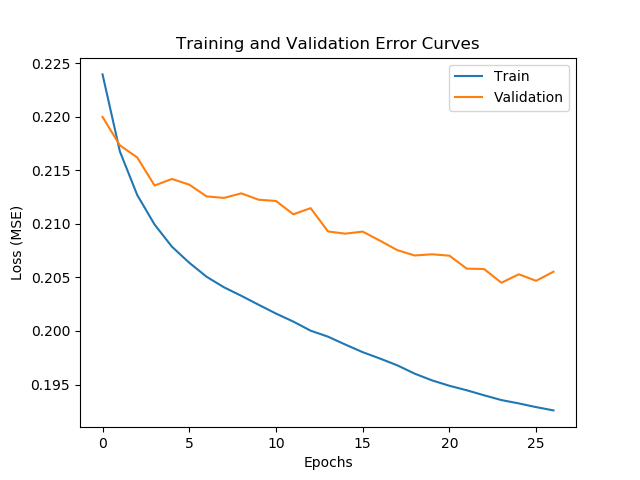

In [15]:
plot_training_error_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [16]:
## Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Matriz de confusão no conjunto de teste:
[[33524     1]
 [63772     2]]

Train Loss:       0.1935
Validation Loss:  0.2045

Performance no conjunto de teste:

Accuracy:         0.3446
Recall:           0.0000
Precision:        0.6667
F1:               0.0001
AUROC:            0.5342
AUPR:             0.6806


# Comparando MLPs com outros classificadores

Agora iremos comparar a performance da nossa rede neural contra outros classificadores e por fim analisar a performance conjunta deles quando treinados em um ensemble.

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

Função auxiliar para criar um classificador compatível com a API do pacote scikit-learn. Modifique a arquitetura da sua rede aqui.

In [18]:
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Cria o classificador, treina, e avalia a performance no conjunto de validação. Apenas quando a melhor combinação de hyperparâmetros for escolhida o classificador deve ser avaliado no conjunto de teste.

In [ ]:
mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)
mlp_clf.fit(x_train, data_y_train)
mlp_pred_class = mlp_clf.predict(x_val)
mlp_pred_scores = mlp_clf.predict_proba(x_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(data_y_val, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Performance no conjunto de validação:

Accuracy:         0.6565
Recall:           0.6667
Precision:        0.6534
F1:               0.6600
AUROC:            0.7157
AUPR:             0.7024


In [ ]:
svc_clf = SVC(probability=True)  # Modifique aqui os hyperparâmetros
svc_clf.fit(X_train, y_train)
svc_pred_class = svc_clf.predict(X_val)
svc_pred_scores = svc_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, svc_pred_class, svc_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
gb_clf = GradientBoostingClassifier()  # Modifique aqui os hyperparâmetros
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
rf_clf = RandomForestClassifier()  # Modifique aqui os hyperparâmetros
rf_clf.fit(X_train, y_train)
rf_pred_class = rf_clf.predict(X_val)
rf_pred_scores = rf_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, rf_pred_class, rf_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
mlp_ens_clf = KerasClassifier(build_fn=create_sklearn_compatible_model,
                              batch_size=64, epochs=50, verbose=0)
svc_ens_clf = SVC(probability=True)
gb_ens_clf = GradientBoostingClassifier()
rf_ens_clf = RandomForestClassifier()
ens_clf = VotingClassifier([('mlp', mlp_ens_clf), ('svm', svc_ens_clf), ('gb', gb_ens_clf), ('rf', rf_ens_clf)], 
                           voting='soft')

ens_clf.fit(X_train, y_train)
ens_pred_class = ens_clf.predict(X_val)
ens_pred_scores = ens_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, ens_pred_class, ens_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Agora vamos analisar a performance final de todos os classificadores treinados e de nosso ensemble no conjunto de teste.

In [ ]:
mlp_pred_class = mlp_clf.predict(X_test)
mlp_pred_scores = mlp_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('MLP')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

svc_pred_class = svc_clf.predict(X_test)
svc_pred_scores = svc_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, svc_pred_class, svc_pred_scores)
print('\n\nSupport Vector Machine')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

gb_pred_class = gb_clf.predict(X_test)
gb_pred_scores = gb_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, gb_pred_class, gb_pred_scores)
print('\n\nGradient Boosting')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

rf_pred_class = rf_clf.predict(X_test)
rf_pred_scores = rf_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, rf_pred_class, rf_pred_scores)
print('\n\nRandom Forest')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

ens_pred_class = ens_clf.predict(X_test)
ens_pred_scores = ens_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, ens_pred_class, ens_pred_scores)
print('\n\nEnsemble')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Baseado no código acima você pode facilmente criar um ensemble de MLPs ou de outros classificadores.